# MIT Indoor Image Classification using PyTorch
#### Kevin Wang


In [ ]:
# IMPORT LIBRARIES and PACKAGES
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, sys, pathlib, random, h5py, PIL, glob
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision.models import ResNet34_Weights
from IPython.display import display

# For reading the bad images
import tensorflow as tf
import tensorflow.compat.v2 as tf

%matplotlib inline

# Introduction

AI company has a 2 GB dataset containing over 15,000 images of indoor locations. Originally from MIT, this dataset was built to work on indoor scene recognition. There are 67 categories of JPEG images. The number of images per category varies, but there are at least 100 images for each category.

Data was obtained from:
https://www.kaggle.com/itsahmad/indoor-scenes-cvpr-2019



## Assign Path to Previously Downloaded Images or Download Images

In [ ]:
from google.colab import drive

# Note: tried to use jupyter notebook from anaconda directly but a recent update caused errors, so using Colab with Gdrive instead.
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Repasted to delete output from html
!unzip gdrive/MyDrive/archive.zip

In [ ]:
#set the parent folder that contains the subfolders that are the lables
img_dir = pathlib.Path('archive/indoorCVPR_09/Images/')
print(f'The indoorCVPR_09 photes are stored in local directory : {img_dir}')

The indoorCVPR_09 photes are stored in local directory : archive/indoorCVPR_09/Images


## List the directories to double-check

In [ ]:
total_files = 0
for root, dirs, files in os.walk(str(img_dir)):
    level = root.replace(str(img_dir), '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/ ({len(files)} files)')
    total_files += len(files)
print(f'There are {total_files} images in this dataset')

Images/ (0 files)
    deli/ (258 files)
    florist/ (103 files)
    artstudio/ (140 files)
    concert_hall/ (103 files)
    classroom/ (113 files)
    poolinside/ (174 files)
    trainstation/ (153 files)
    corridor/ (346 files)
    waitingroom/ (151 files)
    videostore/ (110 files)
    church_inside/ (180 files)
    dentaloffice/ (131 files)
    airport_inside/ (608 files)
    elevator/ (101 files)
    computerroom/ (114 files)
    auditorium/ (176 files)
    bakery/ (405 files)
    museum/ (168 files)
    inside_subway/ (457 files)
    closet/ (135 files)
    warehouse/ (506 files)
    kitchen/ (734 files)
    office/ (109 files)
    kindergarden/ (127 files)
    jewelleryshop/ (157 files)
    toystore/ (347 files)
    restaurant_kitchen/ (107 files)
    hospitalroom/ (101 files)
    movietheater/ (175 files)
    bedroom/ (662 files)
    bookstore/ (380 files)
    bathroom/ (197 files)
    fastfood_restaurant/ (116 files)
    garage/ (103 files)
    gameroom/ (127 files)
    gr

## Get the Indoor Image label using the Image directory

In [ ]:
IndoorImage_dir = [ name for name in list(os.listdir(img_dir)) if os.path.isdir(os.path.join(img_dir, name)) ]
print(f' The Indoor Image labels = {IndoorImage_dir}')

# SORT the directories in alphabetical order
IndoorImage_dir.sort()
print(f'\n The SORTED Indoor Image labels = {IndoorImage_dir}')

print(f'\nThere are {len(IndoorImage_dir)} classes of Indoor Images.') ### There are  (67) classes of Indoor Images.

 The Indoor Image labels = ['deli', 'florist', 'artstudio', 'concert_hall', 'classroom', 'poolinside', 'trainstation', 'corridor', 'waitingroom', 'videostore', 'church_inside', 'dentaloffice', 'airport_inside', 'elevator', 'computerroom', 'auditorium', 'bakery', 'museum', 'inside_subway', 'closet', 'warehouse', 'kitchen', 'office', 'kindergarden', 'jewelleryshop', 'toystore', 'restaurant_kitchen', 'hospitalroom', 'movietheater', 'bedroom', 'bookstore', 'bathroom', 'fastfood_restaurant', 'garage', 'gameroom', 'grocerystore', 'operating_room', 'subway', 'buffet', 'gym', 'shoeshop', 'greenhouse', 'tv_studio', 'winecellar', 'dining_room', 'mall', 'stairscase', 'restaurant', 'bar', 'clothingstore', 'cloister', 'studiomusic', 'casino', 'nursery', 'meeting_room', 'pantry', 'prisoncell', 'hairsalon', 'children_room', 'bowling', 'inside_bus']

 The SORTED Indoor Image labels = ['airport_inside', 'artstudio', 'auditorium', 'bakery', 'bar', 'bathroom', 'bedroom', 'bookstore', 'bowling', 'buffet',

# Please check the images quality and remove the bad images if neccessary

Confirmed no bad images

In [ ]:
img_paths = glob.glob(os.path.join(img_dir,'*/*.*')) # assuming you point to the directory containing the label folders.

bad_paths = []

for image_path in img_paths:
    try:
      img_bytes = tf.io.read_file(image_path)
      decoded_img = tf.io.decode_image(img_bytes)
    except tf.errors.InvalidArgumentError as e:
      print(f"Found bad path {image_path}...{e}")
      bad_paths.append(image_path)

    #print(f"{image_path}: OK")

print("BAD PATHS:")
for bad_path in bad_paths:
    print(f"{bad_path}")

BAD PATHS:


### Setup parameters used to load and process the images which are currently stored as files in a directory

In [ ]:
# Imagenet stats
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

## Train and Validation data creation

In [ ]:
# Using Imagenet means and stds
transform = torchvision.transforms.Compose(
    [   torchvision.transforms.Resize((256,256)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(means, stds) # normalize images here
    ])

dataset = datasets.ImageFolder(img_dir, transform=transform)

# Define the desired split ratio
train_ratio = 0.60

# Use random_split twice to create training and test data (no validation)
train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size
temp_dataset, nouse = random_split(dataset, [train_size, test_size], generator = torch.Generator().manual_seed(SEED))


# Training will be 40% of the total original data and test will be 20%
train_ratio = (2/3)
train_size = int(len(temp_dataset) * train_ratio)
test_size = len(temp_dataset) - train_size
train_dataset, test_dataset = random_split(temp_dataset, [train_size, test_size], generator = torch.Generator().manual_seed(SEED))

# specify batch size etc
batch_size = 32

# Create separate DataLoaders for training, validation, and test
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Check the shape and size of the image data

In [ ]:
for images, labels in train_loader:
    print(f' The images shape = {images.shape}, and the label encoding = {labels}')
    break

print(f'Number of batches in train_loader is: {len(train_loader)}.')
print(f'Number of batches in test_loader is: {len(test_loader)}.')

 The images shape = torch.Size([32, 3, 256, 256]), and the label encoding = tensor([11, 30, 19, 20, 26,  2, 10, 33,  7, 30,  1, 60, 59, 51,  3,  1, 37, 34,
         8, 37, 30, 29, 52,  8, 11, 55, 17, 55, 31, 48, 22, 37])
Number of batches in train_loader is: 176.
Number of batches in test_loader is: 88.


## Visualize the Images

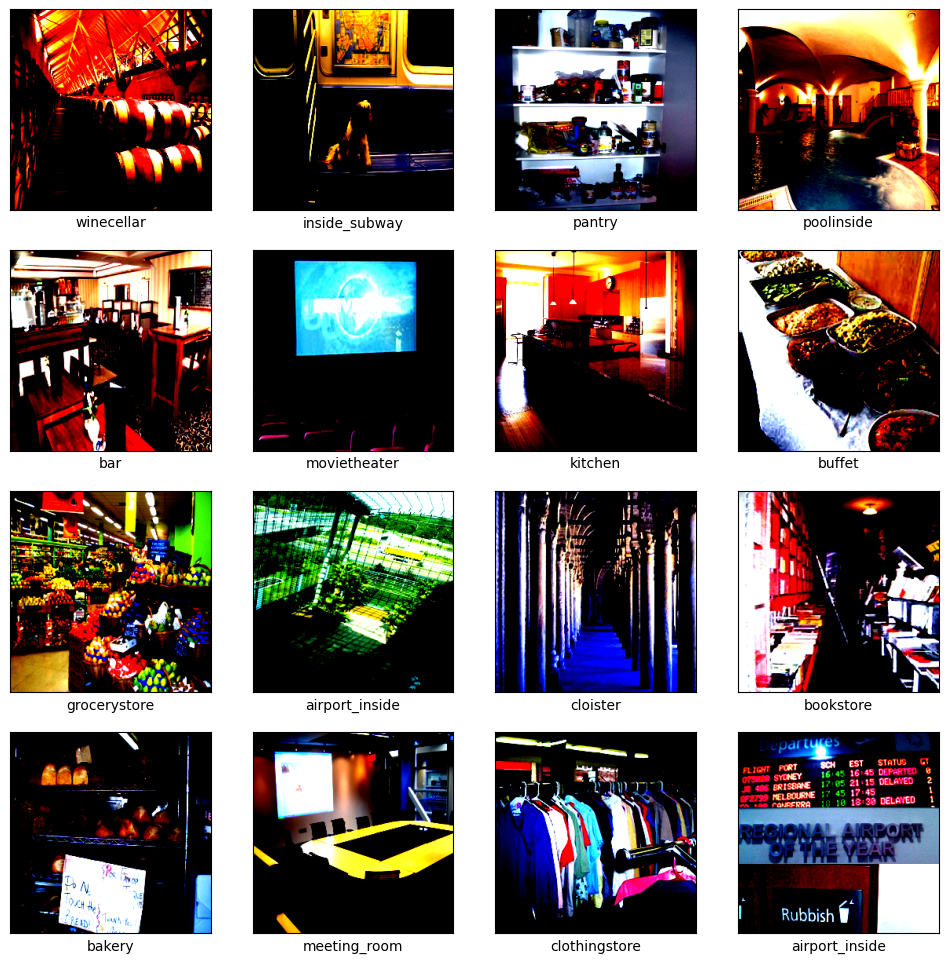

In [ ]:
plt.figure(figsize=(12,12))
for i in range(16): # Only plotting 16 images
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    # Unnormalize it using an inverse transformation with means and stds from before
    img = images[i]
    inverse_normalize = torchvision.transforms.Normalize(
    mean= -1*np.array(means)/np.array(stds),
    std= 1/np.array(stds)
    )
    org_imgorg_img = inverse_normalize(img)
    #convert Tensor to a numpy array
    npimg = img.numpy()
    # Clip values between 0 and 1 due to rounding before
    npimg = np.clip(npimg, 0, 1)
    # each image in PyTorch is in [C, H, W]; where C =axis 0; H =axis =1, W =axis =2
    # Display the image, imshow only support(H, W, C)
    # we need to use np.transpose to rearrange the axis
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xlabel(IndoorImage_dir[labels[i]])
plt.show()

In [ ]:
# Running on GPU, make sure model and data is set to send to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 254, 254]             896
         MaxPool2d-2         [-1, 32, 127, 127]               0
            Conv2d-3         [-1, 64, 125, 125]          18,496
         MaxPool2d-4           [-1, 64, 62, 62]               0
            Conv2d-5          [-1, 128, 60, 60]          73,856
         MaxPool2d-6          [-1, 128, 30, 30]               0
            Linear-7                  [-1, 256]      29,491,456
            Linear-8                  [-1, 128]          32,896
            Linear-9                   [-1, 64]           8,256
           Linear-10                   [-1, 61]           3,965
Total params: 29,629,821
Trainable params: 29,629,821
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 33.59
Params size (MB): 113.03
Es

## Build a CNN model using data augmentation and dropout

In [ ]:
# Redefine CNNNet with dropouts
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3)

        # the in_features of 128 * 30 * 30 was determined using the print trick
        self.fc1 = nn.Linear(128 * 30 * 30, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 61) # 61 unique class labels
        self.dropout = nn.Dropout(0.2) # Dropout in init here

    def forward(self, x):
       # print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #print(f' x= {x.shape}')
        #sys.exit()

        x = x.view(-1, 128 * 30 * 30)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(self.fc4(x)) # Dropout in forward here
        return x
CNN_Model = CNNNet()

In [ ]:
CNN_Model.to(device)

summary(CNN_Model,(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 254, 254]             896
         MaxPool2d-2         [-1, 32, 127, 127]               0
            Conv2d-3         [-1, 64, 125, 125]          18,496
         MaxPool2d-4           [-1, 64, 62, 62]               0
            Conv2d-5          [-1, 128, 60, 60]          73,856
         MaxPool2d-6          [-1, 128, 30, 30]               0
            Linear-7                  [-1, 256]      29,491,456
            Linear-8                  [-1, 128]          32,896
            Linear-9                   [-1, 64]           8,256
           Linear-10                   [-1, 61]           3,965
          Dropout-11                   [-1, 61]               0
Total params: 29,629,821
Trainable params: 29,629,821
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Fo

In [ ]:
# Reload the data using AutoAugment in transform for data augmentation
transform_aug = torchvision.transforms.Compose(
    [   torchvision.transforms.Resize((256,256)),
        torchvision.transforms.AutoAugment(policy=torchvision.transforms.AutoAugmentPolicy.IMAGENET), #AutoAugment for data augmentation
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(means, stds) # normalize images here
    ])

dataset_aug = datasets.ImageFolder(img_dir, transform=transform_aug)

# Define the desired split ratio
train_ratio = 0.60

# Use random_split twice to create training and test data (no validation)
train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size
temp_dataset, nouse = random_split(dataset, [train_size, test_size], generator = torch.Generator().manual_seed(777))


# Training will be 40% of the total original data and test will be 20%
train_ratio = (2/3)
train_size = int(len(temp_dataset) * train_ratio)
test_size = len(temp_dataset) - train_size
train_dataset, test_dataset = random_split(temp_dataset, [train_size, test_size], generator = torch.Generator().manual_seed(777))

# specify batch size etc
batch_size = 32

# Create separate DataLoaders for training, validation, and test
train_loader_aug = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader_aug = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for images, labels in train_loader_aug:
    print(f' The images shape = {images.shape}, and the label encoding = {labels}')
    break
images, labels = images.to(device), labels.to(device)

print(f'Number of batches in train_loader_aug is: {len(train_loader_aug)}.')
print(f'Number of batches in test_loader_aug is: {len(test_loader_aug)}.')

 The images shape = torch.Size([32, 3, 256, 256]), and the label encoding = tensor([ 7, 10, 35, 31, 44, 37, 56, 37, 53,  3, 28,  6, 55, 48, 37, 27, 22,  6,
        45, 29, 53, 22, 19,  0,  8,  0, 10, 49, 46, 41, 37, 60])
Number of batches in train_loader_aug is: 176.
Number of batches in test_loader_aug is: 88.


In [ ]:
%%time
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_Model.parameters(), lr=0.001, momentum=0.9)

# Train the model
report_batchs = 160
EPOCHS = 20
# Pass the whole dataset multiple times to CNN Model
for epoch in range(EPOCHS):

    running_loss = 0.0

    for i, data in enumerate(train_loader_aug, 0):
        # Get the inputs/features and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Reset gradients = 0
        optimizer.zero_grad()

        # Forward progagation to compute the outputs
        outputs = CNN_Model(inputs)
        loss = criterion(outputs, labels)
        # Backward propagation and compute the gradient
        loss.backward()
        # Update the weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % report_batchs == report_batchs -1:
            print(f'[Epoch: {epoch + 1}, batch: [{i+1-report_batchs} to {i+1}]] loss ={running_loss / report_batchs:.2f}')
            running_loss = 0.0

print(f'Completed Training of {EPOCHS} epochs!')

[Epoch: 1, batch: [0 to 160]] loss =4.10
[Epoch: 2, batch: [0 to 160]] loss =4.00
[Epoch: 3, batch: [0 to 160]] loss =3.92
[Epoch: 4, batch: [0 to 160]] loss =3.88
[Epoch: 5, batch: [0 to 160]] loss =3.84
[Epoch: 6, batch: [0 to 160]] loss =3.79
[Epoch: 7, batch: [0 to 160]] loss =3.74
[Epoch: 8, batch: [0 to 160]] loss =3.70
[Epoch: 9, batch: [0 to 160]] loss =3.65
[Epoch: 10, batch: [0 to 160]] loss =3.60
[Epoch: 11, batch: [0 to 160]] loss =3.52
[Epoch: 12, batch: [0 to 160]] loss =3.45
[Epoch: 13, batch: [0 to 160]] loss =3.36
[Epoch: 14, batch: [0 to 160]] loss =3.29
[Epoch: 15, batch: [0 to 160]] loss =3.21
[Epoch: 16, batch: [0 to 160]] loss =3.07
[Epoch: 17, batch: [0 to 160]] loss =2.94
[Epoch: 18, batch: [0 to 160]] loss =2.75
[Epoch: 19, batch: [0 to 160]] loss =2.42
[Epoch: 20, batch: [0 to 160]] loss =2.13
Completed Training of 20 epochs!
CPU times: user 18min 58s, sys: 9.69 s, total: 19min 8s
Wall time: 19min 44s


## Evaluate the CNN Model on test dataset

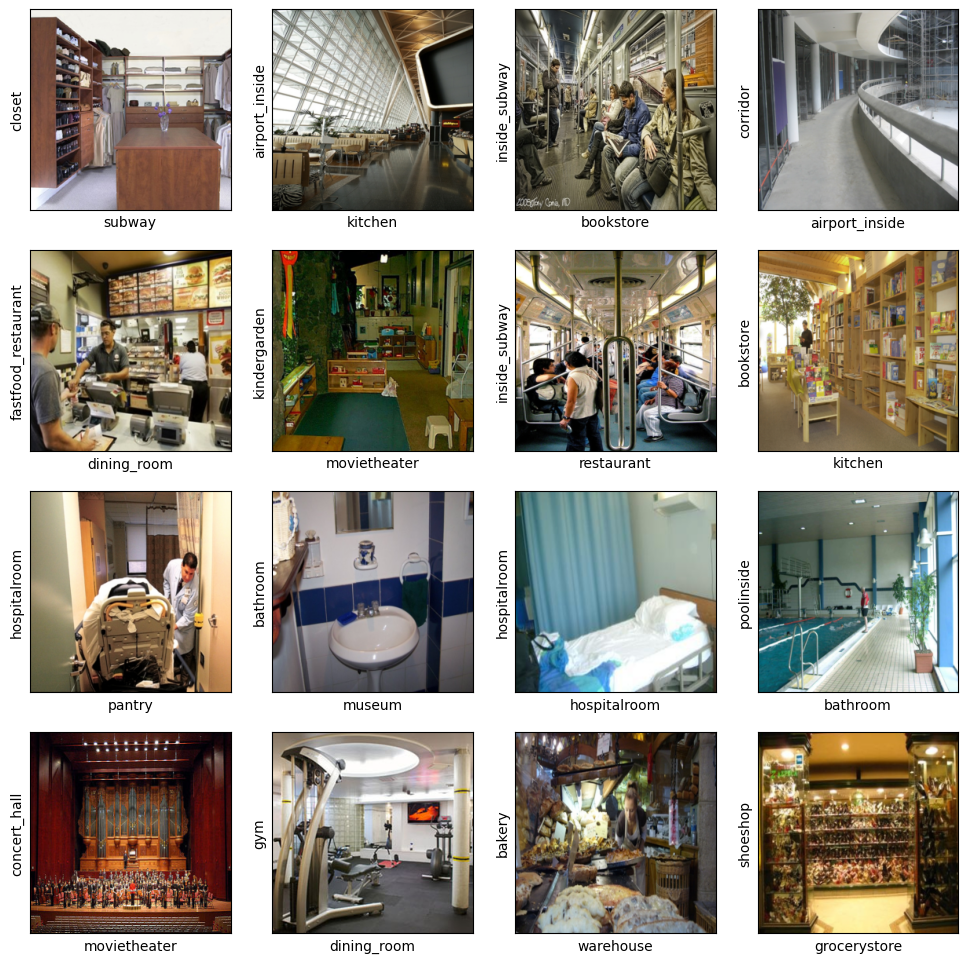

In [ ]:
for images, labels in test_loader_aug:
    break
images, labels = images.to(device), labels.to(device) # GPU

outputs = CNN_Model(images)
# Take out the index of the maximum value
_, predicted_labels = torch.max(outputs, 1)

plt.figure(figsize=(12,12))
for i in range(16): # View 16 images only
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    # Unnormalize it
    img = images[i]
    inverse_normalize = torchvision.transforms.Normalize(
    mean= -1*np.array(means)/np.array(stds),
    std= 1/np.array(stds)
    )
    org_imgorg_img = inverse_normalize(img)
    cpu_tensor = org_imgorg_img.cpu()
    #convert Tensor to a numpy array
    npimg = cpu_tensor.numpy()
    # Clip values between 0 and 1 due to rounding before
    npimg = np.clip(npimg, 0, 1)

    # Display the image, imshow only support(H, W, C)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # Label it with x being predicted and y being actual
    plt.xlabel(IndoorImage_dir[predicted_labels[i]])
    plt.ylabel(IndoorImage_dir[labels[i]])
plt.show()

In [ ]:
%%time
class_correct = list(0. for i in range(61))
class_total = list(0. for i in range(61))
y_test = []
predictions = []

# No need to estimate gradient
with torch.no_grad():
    # loop over the test dataset by taking out a batch of size 4 each time
    for data in test_loader:
        # Seperate the features and labels
        images, labels = data
        images, labels = images.to(device), labels.to(device) # GPU
        # Forecast the labels for a batch of size 4
        outputs = CNN_Model(images)
        # Get the index of the maximum value , which is the predicted class index
        _, predicted = torch.max(outputs, 1)
        # Check wehter the predicted labels matche the actual label index
        c = (predicted == labels).squeeze()

        # Convert back to CPU for np
        cpu_tensor1 = labels.cpu()
        cpu_tensor2 = predicted.cpu()

        y_test.append(cpu_tensor1.numpy())
        predictions.append(cpu_tensor2.numpy())
        # Handle one batch of size  or the last batch with less images
        for i in range(min(len(labels), batch_size)):
            label = labels[i]
            # Update the counters of corrected classes and total classes
            class_correct[label] += c[i].item()
            class_total[label] += 1
#print it out
for i in range(61):
    print(f'Accuracy of {IndoorImage_dir[i]} = {100 * class_correct[i] / class_total[i]:.2f}')

Accuracy of airport_inside = 32.14
Accuracy of artstudio = 24.14
Accuracy of auditorium = 23.26
Accuracy of bakery = 32.63
Accuracy of bar = 29.52
Accuracy of bathroom = 28.89
Accuracy of bedroom = 53.79
Accuracy of bookstore = 37.88
Accuracy of bowling = 32.56
Accuracy of buffet = 4.35
Accuracy of casino = 26.60
Accuracy of children_room = 10.34
Accuracy of church_inside = 37.50
Accuracy of classroom = 21.74
Accuracy of cloister = 21.05
Accuracy of closet = 7.41
Accuracy of clothingstore = 33.33
Accuracy of computerroom = 21.05
Accuracy of concert_hall = 5.56
Accuracy of corridor = 52.50
Accuracy of deli = 22.64
Accuracy of dentaloffice = 16.67
Accuracy of dining_room = 28.85
Accuracy of elevator = 45.00
Accuracy of fastfood_restaurant = 8.00
Accuracy of florist = 20.00
Accuracy of gameroom = 15.79
Accuracy of garage = 23.08
Accuracy of greenhouse = 13.33
Accuracy of grocerystore = 32.00
Accuracy of gym = 24.56
Accuracy of hairsalon = 23.68
Accuracy of hospitalroom = 27.27
Accuracy of

In [ ]:
flat_y = [item for sublist in y_test for item in sublist]
flat_pred = [item for sublist in predictions for item in sublist]

# No confusion matrix due to 61 classes
print(classification_report(flat_y, flat_pred))

              precision    recall  f1-score   support

           0       0.35      0.32      0.33       112
           1       0.15      0.24      0.19        29
           2       0.13      0.23      0.17        43
           3       0.34      0.33      0.33        95
           4       0.49      0.30      0.37       105
           5       0.43      0.29      0.35        45
           6       0.31      0.54      0.39       145
           7       0.24      0.38      0.29        66
           8       0.31      0.33      0.32        43
           9       1.00      0.04      0.08        23
          10       0.68      0.27      0.38        94
          11       0.60      0.10      0.18        29
          12       0.27      0.38      0.32        40
          13       1.00      0.22      0.36        23
          14       0.57      0.21      0.31        19
          15       0.06      0.07      0.07        27
          16       0.50      0.33      0.40        12
          17       0.25    

The model could also have trained on more epochs given loss was still decreasing at the end of training. However, model 2 performs decently given 61 target classes with an overall accuracy of 29% and weighted f1-score of also 0.29. Compared to my model in TF (accuracy: 0.25, f1: 0.22), this PyTorch model actually slightly outperforms it.

Overall, I would say this is an okay model but definitely could have trained on more epochs if I did not run out of free GPU time on Colab.

## Build a model using transfer learning from a pre-trained model

In [ ]:
model_resnet34 = torchvision.models.resnet34(weights = ResNet34_Weights.DEFAULT) # same as pretrained = True
for param in model_resnet34.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet34.fc.in_features

# Define our custom multi-layer classifier
classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),  # First hidden layer with 512 units
    nn.ReLU(),  # ReLU activation
    nn.Dropout(p=0.2),  # Dropout for regularization
    nn.Linear(512, 61)  # Output layer with num_classes units
)

# Replace the pre-trained model's classifier with our custom one
model_resnet34.fc  = classifier

criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer = optim.SGD(model_resnet34.fc.parameters(), lr=0.001, momentum=0.9)

In [ ]:
%%time
# Train the model
report_batchs = 160
EPOCHS = 20
model_resnet34 = model_resnet34.to(device) # Set model to GPU

# Pass the whole dataset multiple times to pretrained Model
for epoch in range(EPOCHS):

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs/features and labels
        inputs, labels = data
        # Running on GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Reset gradients = 0
        optimizer.zero_grad()

        # Forward progagation to compute the outputs
        outputs = model_resnet34(inputs)
        loss = criterion(outputs, labels)
        # Backward propagation and compute the gradient
        loss.backward()
        # Update the weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % report_batchs == report_batchs -1:
            print(f'[Epoch: {epoch + 1}, batch: [{i+1-report_batchs} to {i+1}]] loss ={running_loss / report_batchs:.2f}')
            running_loss = 0.0

print(f'Completed Training of {EPOCHS} epochs!')

[Epoch: 1, batch: [0 to 160]] loss =3.80
[Epoch: 2, batch: [0 to 160]] loss =3.26
[Epoch: 3, batch: [0 to 160]] loss =2.77
[Epoch: 4, batch: [0 to 160]] loss =2.36
[Epoch: 5, batch: [0 to 160]] loss =2.08
[Epoch: 6, batch: [0 to 160]] loss =1.85
[Epoch: 7, batch: [0 to 160]] loss =1.70
[Epoch: 8, batch: [0 to 160]] loss =1.55
[Epoch: 9, batch: [0 to 160]] loss =1.47
[Epoch: 10, batch: [0 to 160]] loss =1.38
[Epoch: 11, batch: [0 to 160]] loss =1.31
[Epoch: 12, batch: [0 to 160]] loss =1.26
[Epoch: 13, batch: [0 to 160]] loss =1.21
[Epoch: 14, batch: [0 to 160]] loss =1.16
[Epoch: 15, batch: [0 to 160]] loss =1.11
[Epoch: 16, batch: [0 to 160]] loss =1.09
[Epoch: 17, batch: [0 to 160]] loss =1.06
[Epoch: 18, batch: [0 to 160]] loss =1.00
[Epoch: 19, batch: [0 to 160]] loss =0.97
[Epoch: 20, batch: [0 to 160]] loss =0.96
Completed Training of 20 epochs!
CPU times: user 18min 9s, sys: 16.4 s, total: 18min 26s
Wall time: 18min 49s


## Evaluate the pre-trained model on test dataset.

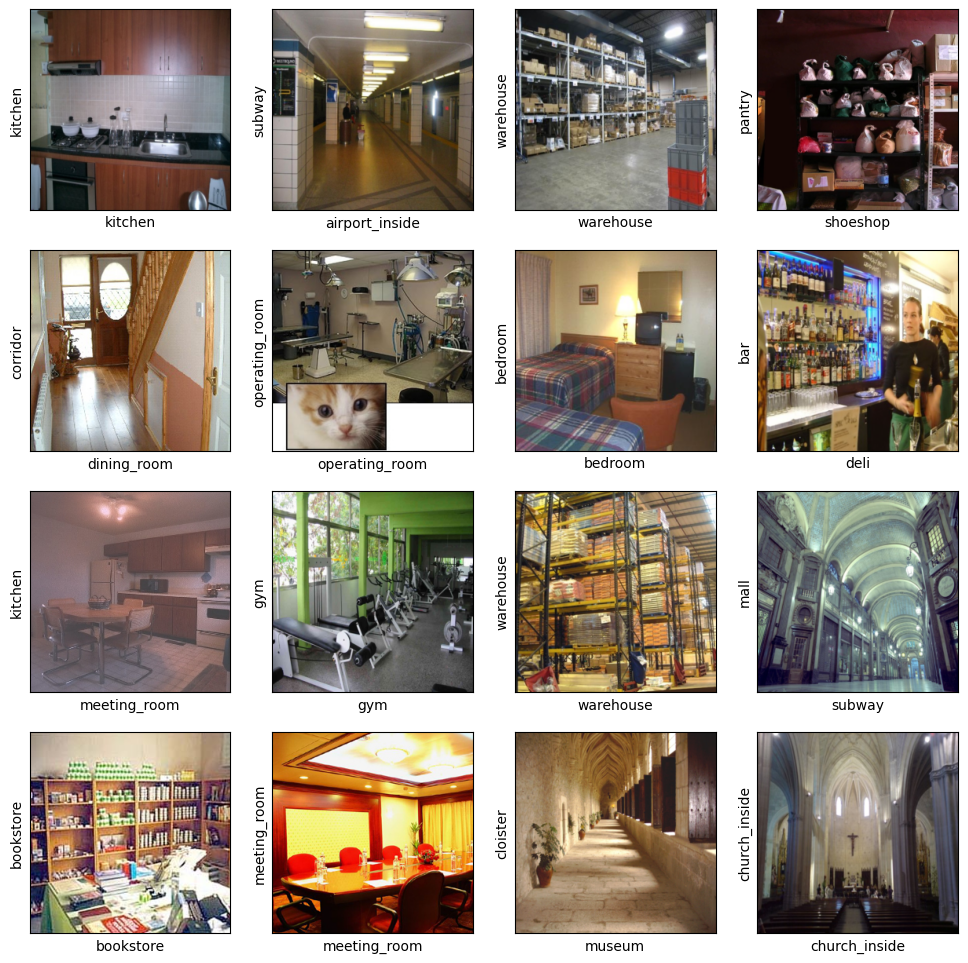

In [ ]:
for images, labels in test_loader:
    break
images, labels = images.to(device), labels.to(device) # GPU
outputs = model_resnet34(images)

# Take out the index of the maximum value
_, predicted_labels = torch.max(outputs, 1)

plt.figure(figsize=(12,12))
for i in range(16): # View 16 images only
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    # Unnormalize it
    img = images[i]
    inverse_normalize = torchvision.transforms.Normalize(
    mean= -1*np.array(means)/np.array(stds),
    std= 1/np.array(stds)
    )
    org_imgorg_img = inverse_normalize(img)

    cpu_tensor = org_imgorg_img.cpu()
    #convert Tensor to a numpy array
    npimg = cpu_tensor.numpy()

    # Clip values between 0 and 1 due to rounding before
    npimg = np.clip(npimg, 0, 1)

    # Display the image, imshow only support(H, W, C)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # Label it with x being predicted and y being actual
    plt.xlabel(IndoorImage_dir[predicted_labels[i]])
    plt.ylabel(IndoorImage_dir[labels[i]])
plt.show()

In [ ]:
%%time
class_correct = list(0. for i in range(61))
class_total = list(0. for i in range(61))
y_test = []
predictions = []

# No need to estimate gradient
with torch.no_grad():
    # loop over the test dataset by taking out a batch of size 4 each time
    for data in test_loader:
        # Seperate the features and labels
        images, labels = data
        images, labels = images.to(device), labels.to(device) # GPU
        # Forecast the labels for a batch of size 4
        outputs = model_resnet34(images)
        # Get the index of the maximum value , which is the predicted class index
        _, predicted = torch.max(outputs, 1)
        # Check wehter the predicted labels matche the actual label index
        c = (predicted == labels).squeeze()

        # Convert back to CPU for np
        cpu_tensor1 = labels.cpu()
        cpu_tensor2 = predicted.cpu()

        y_test.append(cpu_tensor1.numpy())
        predictions.append(cpu_tensor2.numpy())
        # Handle one batch of size  or the last batch with less images
        for i in range(min(len(labels), batch_size)):
            label = labels[i]
            # Update the counters of corrected classes and total classes
            class_correct[label] += c[i].item()
            class_total[label] += 1
#print it out
for i in range(61):
    print(f'Accuracy of {IndoorImage_dir[i]} = {100 * class_correct[i] / class_total[i]:.2f}')

Accuracy of airport_inside = 66.07
Accuracy of artstudio = 31.03
Accuracy of auditorium = 51.16
Accuracy of bakery = 77.89
Accuracy of bar = 59.05
Accuracy of bathroom = 68.89
Accuracy of bedroom = 79.31
Accuracy of bookstore = 72.73
Accuracy of bowling = 69.77
Accuracy of buffet = 47.83
Accuracy of casino = 84.04
Accuracy of children_room = 31.03
Accuracy of church_inside = 82.50
Accuracy of classroom = 56.52
Accuracy of cloister = 78.95
Accuracy of closet = 70.37
Accuracy of clothingstore = 16.67
Accuracy of computerroom = 31.58
Accuracy of concert_hall = 22.22
Accuracy of corridor = 70.00
Accuracy of deli = 32.08
Accuracy of dentaloffice = 55.56
Accuracy of dining_room = 51.92
Accuracy of elevator = 40.00
Accuracy of fastfood_restaurant = 52.00
Accuracy of florist = 85.00
Accuracy of gameroom = 73.68
Accuracy of garage = 26.92
Accuracy of greenhouse = 93.33
Accuracy of grocerystore = 62.00
Accuracy of gym = 77.19
Accuracy of hairsalon = 50.00
Accuracy of hospitalroom = 40.91
Accurac

In [ ]:
flat_y = [item for sublist in y_test for item in sublist]
flat_pred = [item for sublist in predictions for item in sublist]

# No confusion matrix due to 61 classes
print(classification_report(flat_y, flat_pred))

              precision    recall  f1-score   support

           0       0.51      0.66      0.57       112
           1       0.43      0.31      0.36        29
           2       0.51      0.51      0.51        43
           3       0.59      0.78      0.67        95
           4       0.54      0.59      0.56       105
           5       0.74      0.69      0.71        45
           6       0.85      0.79      0.82       145
           7       0.81      0.73      0.77        66
           8       0.91      0.70      0.79        43
           9       0.61      0.48      0.54        23
          10       0.76      0.84      0.80        94
          11       0.47      0.31      0.38        29
          12       0.79      0.82      0.80        40
          13       0.50      0.57      0.53        23
          14       0.68      0.79      0.73        19
          15       0.86      0.70      0.78        27
          16       0.29      0.17      0.21        12
          17       0.50    

## Recommend the best model
Similar to the pre-trained model in my TF notebook, the pretrained resnet model was the best model with an overall accuracy of 64% and weighted f1-score of 0.63, which are basically the same scores I got in my TF notebook.

While the loss was still decreasing at the end of training, epochs 19 to 20 resulted in a decrease in loss of only 0.01. Given more GPU time, I would have run more training epoches until loss stopped decreasing.

Overall, the pre-trained model produces the best scores in accuracy and f-1 on the test data and is my recommended model.

In [ ]:
%%shell
jupyter nbconvert --to html /content/MITIndoorPyTorch.ipynb
